## 0. 載入套件

In [1]:
import librosa
import os
import numpy as np

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
# import xgboost as xgb
# import lightgbm as lgb
# from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)


## 1. 準備數據集：

In [3]:
def get_file_paths(folder_path):
    # 建立一個空列表來存儲所有音樂文件的完整路徑
    file_paths = []

    # 遍歷指定資料夾下的子資料夾
    for genre_folder in os.listdir(folder_path):
        genre_folder_path = os.path.join(folder_path, genre_folder)
        # 確保是目錄
        if os.path.isdir(genre_folder_path):
            # 遍歷每個音樂類型的資料夾
            for file_name in os.listdir(genre_folder_path):
                # 確保是音樂文件
                if file_name.endswith('.wav'):
                    # 將音樂文件的完整路徑添加到列表中
                    file_path = os.path.join(genre_folder_path, file_name)
                    file_paths.append(file_path)
    return file_paths

folder_path = 'music_genre'
file_paths = get_file_paths(folder_path) #一個類型50個音檔, 十個類型共500個音檔

## 2. 特徵提取

In [4]:
def extract_mfcc_features(file_path):
    # 使用librosa庫讀取音樂文件
    y, sr = librosa.load(file_path)
    # 提取音頻特徵，這裡以MFCC為例
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    # 將特徵矩陣攤平成一維向量
    flattened_features = np.mean(mfccs.T, axis=0)  # 可以使用其他特徵或組合特徵
    return flattened_features

def extract_fft_features(file_path):
    # 使用librosa庫讀取音樂文件
    y, sr = librosa.load(file_path)
    # 計算FFT
    fft_features = np.abs(librosa.stft(y))
    # 將FFT特徵攤平成一維向量
    flattened_features = np.mean(fft_features, axis=1)
    return flattened_features

def extract_rhythm_features(file_path):
    # 使用librosa庫讀取音樂文件
    y, sr = librosa.load(file_path)
    # 提取節奏特徵
    rhythm_features = librosa.feature.tempogram(y=y, sr=sr)
    # 將節奏特徵攤平成一維向量
    flattened_features = np.mean(rhythm_features, axis=1)
    return flattened_features

def extract_pitch_features(file_path):
    # 使用librosa庫讀取音樂文件
    y, sr = librosa.load(file_path)
    # 提取音高輪廓
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    # 將音高輪廓特徵攤平成一維向量
    flattened_features = np.mean(pitches, axis=1)
    return flattened_features

def extract_all_features(file_path):
    flattened_features = []
    # 使用librosa庫讀取音樂文件
    y, sr = librosa.load(file_path)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    flattened_features_mfcc = np.mean(mfccs.T, axis=0)  # 可以使用其他特徵或組合特徵

    fft_features = np.abs(librosa.stft(y))
    flattened_features_fft = np.mean(fft_features, axis=1)

    rhythm_features = librosa.feature.tempogram(y=y, sr=sr)
    flattened_features_rhythm = np.mean(rhythm_features, axis=1)

    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    flattened_features_pitch = np.mean(pitches, axis=1)

    flattened_features.extend(flattened_features_mfcc)
    flattened_features.extend(flattened_features_fft)
    flattened_features.extend(flattened_features_rhythm)
    flattened_features.extend(flattened_features_pitch)

    return flattened_features

def load_data(file_paths, extract_features):
    features = []
    labels = []
    for path in file_paths:
        # 提取特徵
        features.append(extract_features(path))

        label = path.split('/')[1]  # 假設文件路徑為'music_genre/disco/disco.00049.wav'
        labels.append(label)
    return np.array(features), np.array(labels)

In [4]:
feature_extraction_methods = {
      'mfcc': 'extract_mfcc_features',
       'fft': 'extract_fft_features',
    'rhythm': 'extract_rhythm_features',
     'pitch': 'extract_pitch_features',
       'all': 'extract_all_features'
}

## 3. 建立模型

In [5]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    # 'XGBoost': xgb.XGBClassifier(),
    # 'LightGBM': lgb.LGBMClassifier(),
    # 'CatBoost': CatBoostClassifier()
}

## 4. 選擇模型
- 透過 5-fold Cross Validation 來決定較佳的模型與特徵提取方法

In [6]:
music_genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
genre_to_int = {genre: i for i, genre in enumerate(music_genres)}

In [7]:
# 定義 5-fold 交叉驗證
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 遍歷所有特徵提取方法和模型組合
for feature_method_name, feature_method in feature_extraction_methods.items():
    # 提取特徵
    X, y = load_data(file_paths, eval(feature_method))
    print('------------------------------------------------------')
    print('num of features:',len(X[0]),'\n')

    for model_name, model in models.items():
        accuracies = []
         
        # 遍歷每個 fold
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # 對數據進行特徵縮放
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test  = scaler.transform(X_test)
            
            # 將音樂類型轉換為整數
            # y_train = [genre_to_int[genre] for genre in y_train]
            # y_test  = [genre_to_int[genre] for genre in y_test]

            # 訓練模型
            model.fit(X_train, y_train)
            
            # 預測並計算準確率
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)
        
        # 輸出每個 fold 的準確率
        print(f"{feature_method_name} with {model_name} - Average accuracy: {np.mean(accuracies):.3f}")

------------------------------------------------------
num of features: 13 

mfcc with LogisticRegression - Average accuracy: 0.632
mfcc with RandomForest - Average accuracy: 0.656
mfcc with GradientBoosting - Average accuracy: 0.592
mfcc with AdaBoost - Average accuracy: 0.264
mfcc with SVM - Average accuracy: 0.660
mfcc with KNN - Average accuracy: 0.628
------------------------------------------------------
num of features: 1025 

fft with LogisticRegression - Average accuracy: 0.624
fft with RandomForest - Average accuracy: 0.648
fft with GradientBoosting - Average accuracy: 0.642
fft with AdaBoost - Average accuracy: 0.164
fft with SVM - Average accuracy: 0.584
fft with KNN - Average accuracy: 0.602
------------------------------------------------------
num of features: 384 

rhythm with LogisticRegression - Average accuracy: 0.320
rhythm with RandomForest - Average accuracy: 0.398
rhythm with GradientBoosting - Average accuracy: 0.384
rhythm with AdaBoost - Average accuracy: 0.22

## 5. 選擇超參數
- 透過 5-fold Cross Validation 來決定模型的超參數

In [9]:
X, y = load_data(file_paths, extract_all_features)

# 将数据拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)

# 定义要调优的超参数范围
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # 决策树的数量
    'max_depth': [None, 5, 10, 20, 30],  # 树的最大深度
    'min_samples_split': [2, 5, 10],  # 节点分裂所需的最小样本数
    'min_samples_leaf': [1, 2, 4],  # 叶节点所需的最小样本数
    'max_features': ['auto', 'sqrt', 'log2'],  # 每个节点分裂时考虑的最大特征数
    'criterion': ['gini', 'entropy'],  # 分裂节点时的评估准则
    # 其他超参数可以继续添加
}

# 使用GridSearchCV进行超参数搜索
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 输出最佳参数组合
print("Best Parameters:", grid_search.best_params_)


/home/re6121011/miniconda3/envs/Roy/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [   nan    nan    nan ... 0.65   0.655  0.6525]
  warnings.warn(


Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


## 6. 配適最終模型

In [21]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.67


In [22]:
model = RandomForestClassifier(n_estimators=100,
                               criterion='gini',
                               max_depth=None,
                               min_samples_leaf=1,
                               min_samples_split=2,
                               max_features='sqrt',
                               random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.69


## 7. 視覺化

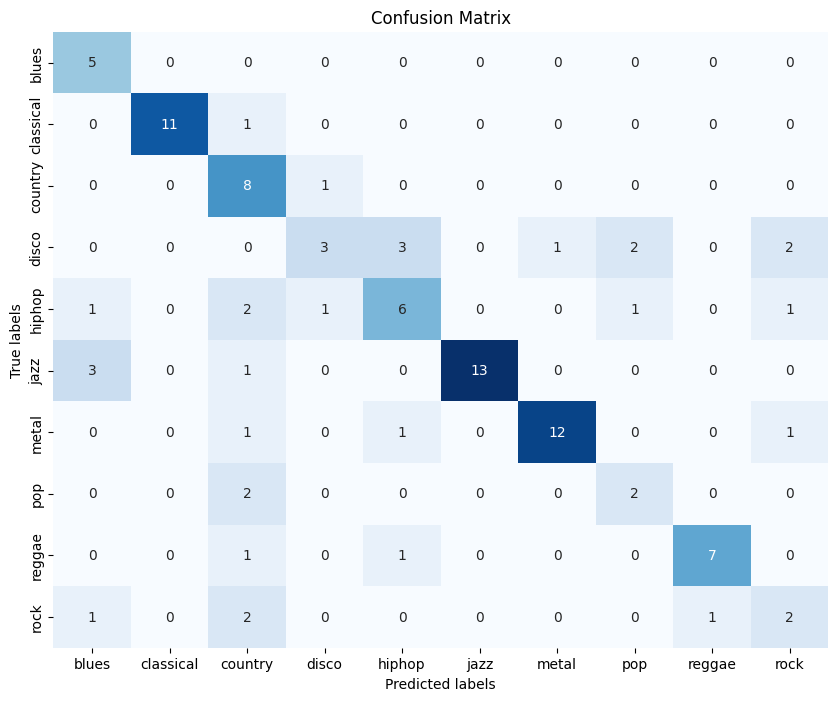

In [24]:
# 定義類別標籤
class_labels = np.unique(y)

# 計算混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred)

# 將混淆矩陣視覺化
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(class_labels))+0.5, labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels))+0.5, labels=class_labels)
plt.show()